In [1]:
import time
import pooch
import pyproj
import numpy as np
import xarray as xr
import boule as bl
import verde as vd
import matplotlib.pyplot as plt

from boost_and_layouts import (
    EQLHarmonicBoost,
    block_averaged_sources,
    combine_parameters,
)


## Download Australia gravity data

In [2]:
fname = pooch.retrieve(
    url="https://github.com/compgeolab/australia-gravity-data/releases/download/v1.0/australia-ground-gravity.nc",
    known_hash="sha256:50f2fa53c5dc2c66dd3358b8e50024d21074fcc77c96191c549a10a37075bc7e",
    downloader=pooch.HTTPDownloader(progressbar=True),
)

# Load the data with xarray
data = xr.load_dataset(fname)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
data

<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

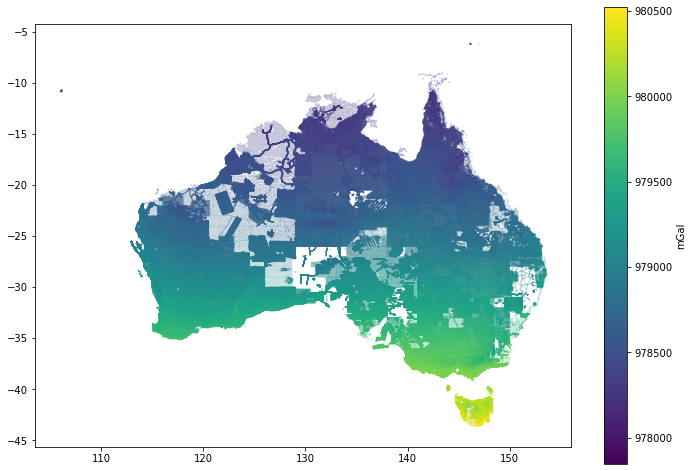

In [4]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Compute gravity disturbance

In [5]:
ell = bl.WGS84
disturbance = data.gravity - ell.normal_gravity(data.latitude, data.height)
data["disturbance"] = ("point", disturbance)

In [6]:
data

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    disturbance        (point) float64 -4.502 -3.588 -3.967 ... 7.314 11.59
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

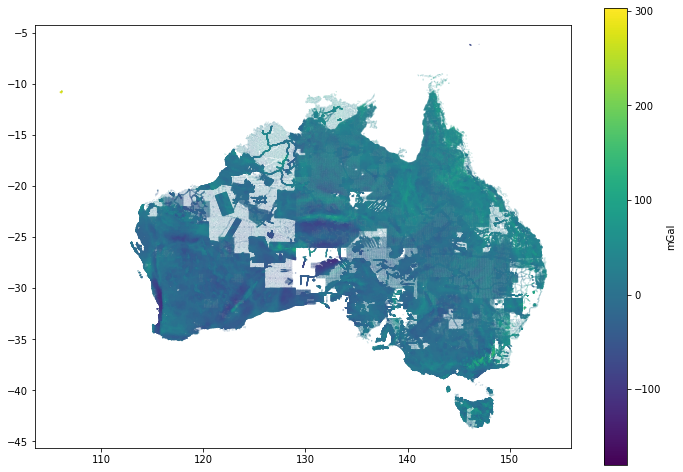

In [7]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Keep only points close to the continent

In [8]:
coordinates = (data.longitude.values, data.latitude.values, data.height.values)
disturbance = data.disturbance.values

vd.get_region(coordinates)

(105.93008499999999, 153.61476, -43.735188, -6.12522)

In [9]:
inside = vd.inside(coordinates, region=(111, 154, -44, -7))
coordinates = tuple(c[inside] for c in coordinates)
disturbance = disturbance[inside]

In [10]:
vd.get_region(coordinates)

(112.934764, 153.61476, -43.735188, -9.008531999999999)

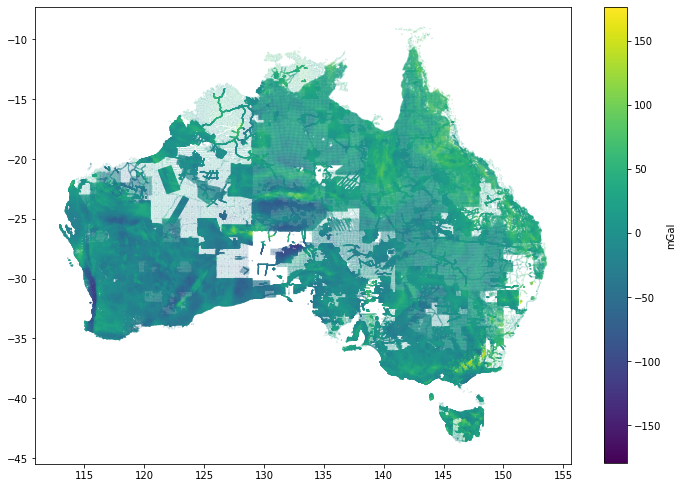

In [11]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*coordinates[:2], c=disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Project coordinates

In [12]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.values.mean())

easting, northing = projection(*coordinates[:2])
proj_coordinates = (easting, northing, coordinates[-1])

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


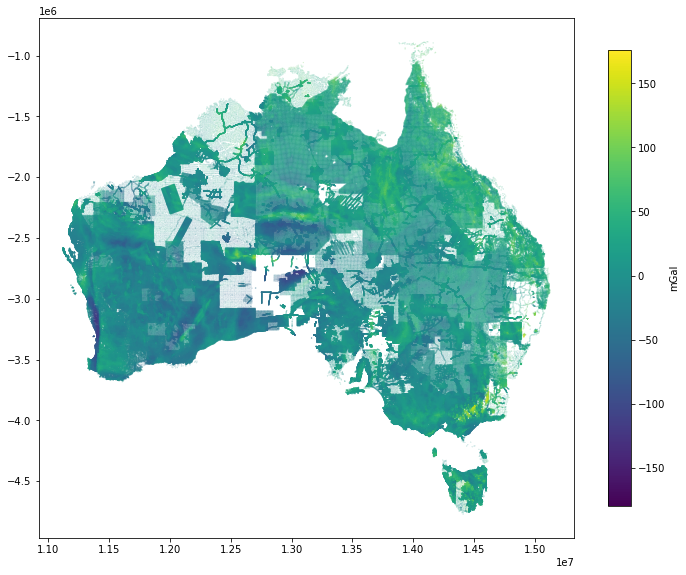

In [13]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*proj_coordinates[:2], c=disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Estimate parameters: spacing for block-averaged sources and window size for gradient boosting

Estimate the block spacing that we will use for block-averaged sources

In [14]:
# Get number of data points
n_data = proj_coordinates[0].size
print("Number of data points: {}".format(n_data))

Number of data points: 1789755


In [15]:
spacings = np.linspace(4e3, 10e3, 7)

n_data_per_sources = []
for spacing in spacings:
    sources = block_averaged_sources(
        proj_coordinates, spacing=spacing, depth_type="relative_depth", depth=0
    )
    n_data_per_sources.append(n_data / sources[0].size)

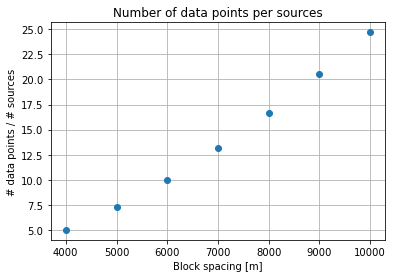

In [16]:
plt.plot(spacings, n_data_per_sources, "o")
plt.xlabel("Block spacing [m]")
plt.ylabel("# data points / # sources")
plt.title("Number of data points per sources")
plt.grid()
plt.show()

Lets choose a block spacing of 6000m so we obtain ~10 data points per source

In [17]:
spacing = 6000

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Estimate the window size for gradient boosting

In [18]:
window_sizes = np.linspace(100e3, 1000e3, 10)

# Create sources with the spacing obtained before
sources = block_averaged_sources(
    proj_coordinates, spacing=spacing, depth_type="relative_depth", depth=0
)

memory_gb = []
for window_size in window_sizes:
    eql = EQLHarmonicBoost(window_size=window_size)
    eql.points_ = sources
    source_windows, data_windows = eql._create_rolling_windows(proj_coordinates)
    # Get the size of each source and data windows
    source_sizes = np.array([w.size for w in source_windows])
    data_sizes = np.array([w.size for w in data_windows])
    # Compute the size of the Jacobian matrix for each window
    jacobian_sizes = source_sizes * data_sizes
    # Register the amount of memory to store the Jacobian matrix (double precision)
    memory_gb.append(jacobian_sizes.max() * (64 / 8) / 1024 ** 3)

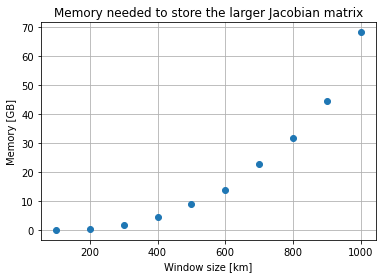

In [19]:
plt.plot(window_sizes * 1e-3, memory_gb, "o")
plt.xlabel("Window size [km]")
plt.ylabel("Memory [GB]")
plt.title("Memory needed to store the larger Jacobian matrix")
plt.grid()
plt.show()

### Conclusions:

- Choose a spacing of 6000m so we obtain ~10 data points per source
- Choose a window size of 500km so we don't exceed 10GB of RAM.

In [20]:
window_size = 500e3
spacing = 6e3

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Cross-validate gridder for estimating parameters

Choose only a portion of the data to apply CV to speed up things

In [21]:
easting_0, northing_0 = 13783825.0, -3661038.0
easting_size, northing_size = 550e3, 550e3
smaller_region = (
    easting_0,
    easting_0 + easting_size,
    northing_0,
    northing_0 + northing_size,
)

inside = vd.inside(proj_coordinates, region=smaller_region)
proj_coords_cv = tuple(c[inside] for c in proj_coordinates)
disturbance_cv = disturbance[inside]

print(f"Number of data points for CV: {proj_coords_cv[0].size}")
print(f"Small region: {vd.get_region(proj_coords_cv)}")

Number of data points for CV: 99139
Small region: (13783825.71330877, 14333796.153411591, -3660991.3781428044, -3111062.8714506407)


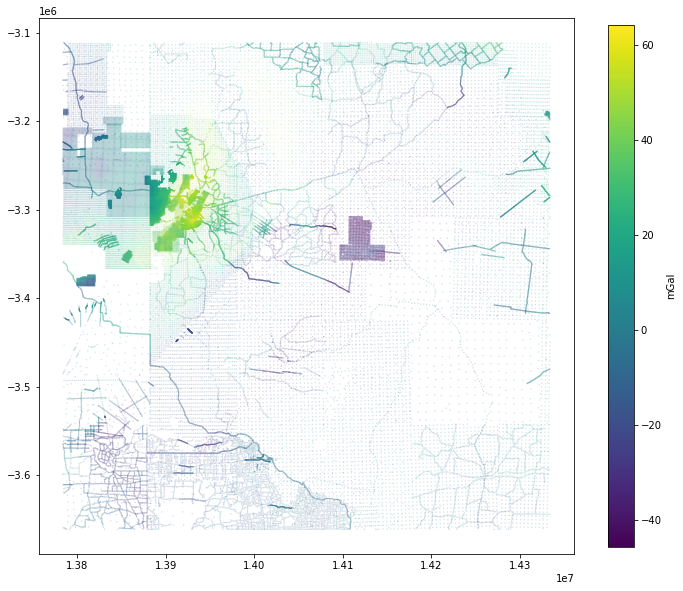

In [22]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*proj_coords_cv[:2], c=disturbance_cv, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.8)
plt.show()

Define parameters space

In [23]:
depth_type = "relative_depth"
random_state = 0
dampings = np.logspace(-2, 3, 6)
depths = [10e3, 15e3, 20e3, 25e3, 30e3, 35e3]

# Combine these parameters
parameter_sets = combine_parameters(
    **dict(
        depth_type=depth_type,
        depth=depths,
        damping=dampings,
        spacing=spacing,
        window_size=window_size,
        random_state=random_state,
    )
)
print("Number of combinations:", len(parameter_sets))

Number of combinations: 36


Find mean distance to nearest neighbors in order to choose a proper block spacing for cross validation

9256.18797269895


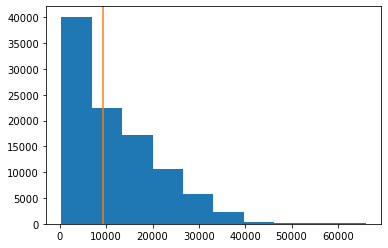

In [24]:
distances = vd.median_distance(proj_coords_cv, k_nearest=500)
median_distance = np.median(distances)
print(median_distance)

plt.hist(distances)
plt.axvline(median_distance, c="C1")
plt.show()

Apply cross validation

In [25]:
%%time
cv = vd.BlockKFold(spacing=20e3, n_splits=6, shuffle=True, random_state=0)

scores = []
for parameters in parameter_sets:
    points = block_averaged_sources(proj_coords_cv, **parameters)
    eql = EQLHarmonicBoost(
        points=points,
        damping=parameters["damping"],
        window_size=parameters["window_size"],
        random_state=parameters["random_state"],
    )
    start = time.time()
    score = np.mean(
        vd.cross_val_score(
            eql,
            proj_coords_cv,
            disturbance_cv,
            cv=cv,
            scoring="neg_root_mean_squared_error",
        )
    )
    end = time.time()
    print("Last CV took: {:.0f}s".format(end - start))
    scores.append(score)

Last CV took: 147s
Last CV took: 145s
Last CV took: 145s
Last CV took: 145s
Last CV took: 145s
Last CV took: 144s
Last CV took: 145s
Last CV took: 144s
Last CV took: 144s
Last CV took: 146s
Last CV took: 152s
Last CV took: 150s
Last CV took: 148s
Last CV took: 150s
Last CV took: 148s
Last CV took: 152s
Last CV took: 151s
Last CV took: 150s
Last CV took: 149s
Last CV took: 148s
Last CV took: 152s
Last CV took: 149s
Last CV took: 149s
Last CV took: 148s
Last CV took: 153s
Last CV took: 148s
Last CV took: 148s
Last CV took: 152s
Last CV took: 153s
Last CV took: 151s
Last CV took: 152s
Last CV took: 148s
Last CV took: 151s
Last CV took: 149s
Last CV took: 150s
Last CV took: 150s
CPU times: user 7h 7min 4s, sys: 1h 19min 14s, total: 8h 26min 18s
Wall time: 1h 29min 12s


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


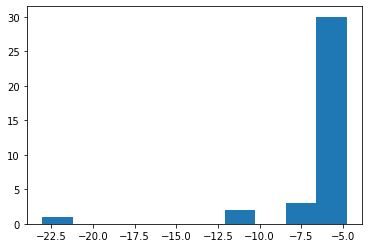

In [26]:
plt.hist(scores)
plt.show()

In [27]:
for score, param in zip(scores, parameter_sets):
    print(score, param)

-23.035592977614076 {'depth_type': 'relative_depth', 'depth': 10000.0, 'damping': 0.01, 'spacing': 6000.0, 'window_size': 500000.0, 'random_state': 0}
-10.73993481183488 {'depth_type': 'relative_depth', 'depth': 10000.0, 'damping': 0.1, 'spacing': 6000.0, 'window_size': 500000.0, 'random_state': 0}
-6.5942108109375965 {'depth_type': 'relative_depth', 'depth': 10000.0, 'damping': 1.0, 'spacing': 6000.0, 'window_size': 500000.0, 'random_state': 0}
-5.727132230228317 {'depth_type': 'relative_depth', 'depth': 10000.0, 'damping': 10.0, 'spacing': 6000.0, 'window_size': 500000.0, 'random_state': 0}
-5.556667057816328 {'depth_type': 'relative_depth', 'depth': 10000.0, 'damping': 100.0, 'spacing': 6000.0, 'window_size': 500000.0, 'random_state': 0}
-5.675620336259718 {'depth_type': 'relative_depth', 'depth': 10000.0, 'damping': 1000.0, 'spacing': 6000.0, 'window_size': 500000.0, 'random_state': 0}
-10.303273081899086 {'depth_type': 'relative_depth', 'depth': 15000.0, 'damping': 0.01, 'spacing'

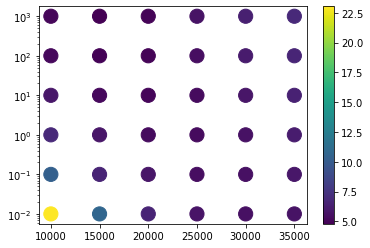

In [28]:
depths_m, dampings_m = np.meshgrid(depths, dampings)
scores_2d = np.array(scores).reshape(depths_m.shape)

plt.scatter(depths_m, dampings_m, c=np.abs(scores_2d), s=200)
plt.yscale("log")
plt.colorbar()
plt.show()

In [29]:
best_score = np.max(scores)
best_parameters = parameter_sets[np.argmax(scores)]

print(best_score)
print(best_parameters)

-4.7957967497216245
{'depth_type': 'relative_depth', 'depth': 35000.0, 'damping': 0.1, 'spacing': 6000.0, 'window_size': 500000.0, 'random_state': 0}


## Cross validate using the entire dataset

In [30]:
%%time
points = block_averaged_sources(proj_coordinates, **best_parameters)
eql = EQLHarmonicBoost(
    points=points,
    damping=best_parameters["damping"],
    window_size=window_size,
    random_state=best_parameters["random_state"],
)
scores = vd.cross_val_score(
    eql,
    proj_coordinates,
    disturbance,
    cv=cv,
    scoring="neg_root_mean_squared_error",
)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/verde/base/least_squares.py:53: UserWarning: Under-determined problem detected (ndata, nparams)=(28, 32).
  jacobian.shape
/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/verde/base/least_squares.py:53: UserWarning: Under-determined problem detected (ndata, nparams)=(241, 299).
  jacobian.shape
/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/verde/base/least_squares.py:53: UserWarning: Under-determined problem detected (ndata, nparams)=(20, 32).
  jacobian.shape
/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/verde/base/least_squares.py:53: UserWarning: Under-determined problem detected (ndata, nparams)=(12, 13).
  jacobian.shape
/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/verde/base/least_squares.py:53: UserWarning: Under-determined problem detected (ndata, nparams)=(268, 299).
  jacobian.sh

CPU times: user 19h 57min 48s, sys: 3h 10min 41s, total: 23h 8min 30s
Wall time: 3h 29min 48s


In [31]:
print(scores)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[-8.37859287 -9.05047647 -8.34169958 -7.56370632 -7.2715634  -7.4244855 ]


## Grid gravity disturbance

In [32]:
points = block_averaged_sources(proj_coordinates, **best_parameters)

In [33]:
memory_gb = proj_coordinates[0].size * points[0].size * (64 / 8) / 1024 ** 3

print("Number of data points:", proj_coordinates[0].size)
print("Number of sources:", points[0].size)
print("Memory needed to store the full Jacobian matrix: {:.2f} GB".format(memory_gb))

Number of data points: 1789755
Number of sources: 178935
Memory needed to store the full Jacobian matrix: 2386.05 GB


In [34]:
%%time
eql = EQLHarmonicBoost(
    points=points,
    damping=best_parameters["damping"],
    window_size=best_parameters["window_size"],
    random_state=best_parameters["random_state"],
)
eql.fit(proj_coordinates, disturbance)

CPU times: user 3h 50min 56s, sys: 45min 6s, total: 4h 36min 2s
Wall time: 45min 13s


EQLHarmonicBoost(damping=0.1,
                 points=(array([14411127.63932425, 14401839.90184096, 14403283.85585468, ...,
       14164789.14365786, 14113756.99691306, 14120484.48755517]),
                         array([-4771579.81016954, -4759639.12418224, -4755550.10628674, ...,
        -895601.91827507,  -884706.64306358,  -886852.78427801]),
                         array([-35002.223, -34834.246, -34926.188, ..., -34916.67 , -34919.547,
       -34920.13 ], dtype=float32)),
                 random_state=0, window_size=500000.0)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


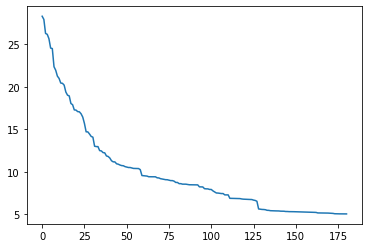

In [35]:
plt.plot(eql.errors_)
plt.show()

In [36]:
%%time
# Get region of longitude, latitude coordinates (in degrees)
region = vd.get_region(coordinates)
# Interpolate on a regular grid on geographic coordinates
grid = eql.grid(
    upward=data.height.values.max(),
    region=region,
    spacing=0.02,
    projection=projection,
    dims=("latitude", "longitude"),
)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 44min 48s, sys: 0 ns, total: 44min 48s
Wall time: 3min 13s


In [37]:
grid

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:    (latitude: 1737, longitude: 2035)
Coordinates:
  * longitude  (longitude) float64 112.9 113.0 113.0 113.0 ... 153.6 153.6 153.6
  * latitude   (latitude) float64 -43.74 -43.72 -43.7 ... -9.049 -9.029 -9.009
    upward     (latitude, longitude) float64 2.128e+03 2.128e+03 ... 2.128e+03
Data variables:
    scalars    (latitude, longitude) float64 0.8669 0.8663 ... 16.01 15.99
Attributes:
    metadata:  Generated by EQLHarmonicBoost(damping=0.1,\n                 p...

In [38]:
grid_masked = vd.distance_mask(
    coordinates, maxdist=80e3, grid=grid, projection=projection
)

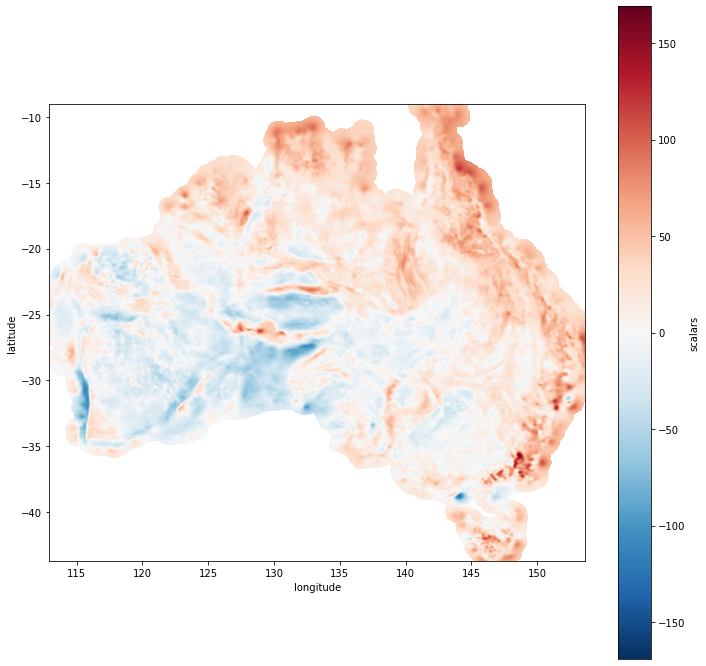

In [39]:
plt.figure(figsize=(12, 12))
grid_masked.scalars.plot()
plt.gca().set_aspect("equal")
plt.show()

In [43]:
region = (128, 135, -35, -25)

subgrid = grid_masked.sel(longitude=slice(*region[:2]), latitude=slice(*region[2:]))

inside = vd.inside(coordinates, region)
scatter = [c[inside] for c in coordinates]
disturbance_portion = disturbance[inside]


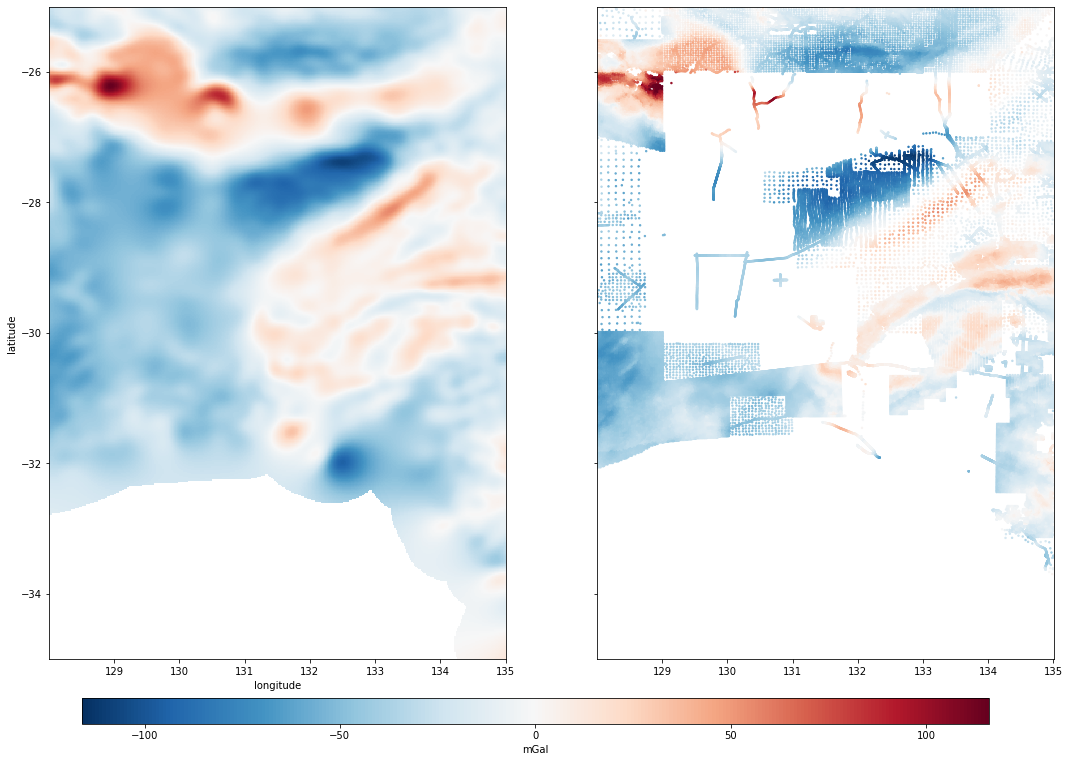

In [81]:
maxabs = vd.maxabs(subgrid.scalars.values)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 12), sharey=True, sharex=True)
subgrid.scalars.plot(ax=ax1, add_colorbar=False)
ax1.set_aspect("equal")

tmp = ax2.scatter(*scatter[:2], c=disturbance_portion, s=2, vmin=-maxabs, vmax=maxabs, cmap="RdBu_r")
ax2.set_aspect("equal")

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
fig.colorbar(tmp, cax=cbar_ax, orientation="horizontal", label="mGal")

plt.show()